In [2]:
%matplotlib inline
import sys
import pandas as pd
import matplotlib.pylab as plt
import re
import numpy as np
import pickle
import datetime as dt # for ticking POSIX clock see http://www.ucolick.org/~sla/leapsecs/epochtime.html
import math
from collections import Counter
import networkx as nx
import json
import time

In [2]:
# converting to datetime and adding the timezone (3600s) as pandas offers no functionality for this
#df_feed['timestamp'] = pd.to_datetime(df_feed['timestamp'] + 3600 ,unit='s')

In [3]:
# ----------------- #
## Handle raw data ##
# ----------------- #

def datetime_to_posix(year,month,day,hour=0,minute=0,second=0):
    """Return posix time, given datetime
    """
    return ( time.mktime( dt.datetime(year,month,day,hour,minute,second).timetuple() ) )
                       
                       
def time_bin_network(df, window=3600):
    """Return iterator to partition network in 'window'-sized bins.
    
    Parameters
    ----------
    df : network dataframe
        Pandas dataframe with network loaded straight from csv.
    window : bin-size integer
        Size of network bins in seconds. This number controls
        the amount of bins.
        
    Returns
    -------
    df_slice : iterator
        Iterator object that yields one bin at a time.
    """
    
    try:
        assert window >= 300
        window += 0.01
    except AssertionError:
        raise AssertionError("""'window' must be greater than, \
or equal to 300.""")
        
    # Get timestamp column and extreme values
    col_t = df["timestamp"]
    min_t = min(col_t)
    max_t = max(col_t)    
    
    # Get timespan and number of network splits - requires traversing data twice per split - good thing its 
    delta_time = max_t - min_t
    
    n_splits = int(math.ceil(delta_time/float(window)))

    for i in range(n_splits):
        lower_bound = df["timestamp"] > min_t + i*window
        upper_bound = df["timestamp"] < min_t + (i+1)*window
        df_slice = df[lower_bound][upper_bound]
        yield df_slice
        
        
def dump_binned_network(df, binsize, filename, kind):
    """Calls binned_network and store binned network into local file
    
    Parameters
    ----------
    df : network dataframe
        Pandas dataframe with network
    binsize : int
        Size of bins in resulting network
    filename : str
        Name of resulting file
    """
    
    binned_network = list(time_bin_network(df, window=binsize))
    
    with open('../Data/processed_data/binned_networks/'+kind+'/'+filename+'.pickle', 'w') as outfile:
        pickle.dump(binned_network, outfile)
        
            
def load_binned_network(kind,filename):
    with open('../Data/processed_data/binned_networks/'+kind+'/'+filename+'.pickle', 'r') as infile:
        return pickle.load(infile)

In [4]:
# ----------------------- #
## Reformat layered data ##
# ----------------------- #

def network_reformat_multiplex(layers, halflife=-1, prefactor=0, clamp_weights=0, normalize_intra=False, interfunc='expdec', step1=0.1):
    """Return multiplex representation of multiplex network
    
    Parameters
    ----------
    halflife : number
        Halflife in seconds of relax-rate decay between layers.
        Defaults to -1.
    layers : pandas df formatted layers
        
    Returns
    -------
    net_file : string
        A network string in multiplex format
    int_to_hash : dict
        Key-value pairs of node integer id and original hash id
    """
    
    # Infomap will only work with node ids as indices.
    
    # Get all node ids in original md5 hash values
    nodes = set()
    for l, df in enumerate(layers):
        layer_nodes = set()
        layer_nodes.update(df["user1"])
        layer_nodes.update(df["user2"])
        nodes.update(layer_nodes)
        
    
    ##########################
    ## Add vertices to file ##
    ##########################
    
    out_file = "*Vertices %d" % len(nodes)
    
    # Node name book-keeping, and adding to file
    hashid_to_intid = {}
    intid_to_hashid = {}
    for i,n in enumerate(nodes):
        intid = i+1
        hashid = str(n)
        out_file += '\n%d "Node %s" 1.0' % (intid,hashid)
        hashid_to_intid[hashid] = intid
        intid_to_hashid[intid] = hashid

        
    #############################
    ## Add Intra-edges to file ##
    #############################
    
    out_file += "\n*Multiplex\n# Intra edges: layer node layer node weight"
    
    for l, df in enumerate(layers):
        user1 = df["user1"]
        user2 = df["user2"]
            
        edges = zip(user1, user2)
        max_w = Counter(edges).most_common()[0][1]
        
        # Add weights. REDUNDANT FOR 5MINS TIMESLICES BECAUSE PPL ONLY MEET ONCE HERE.
        if clamp_weights > 0:
            edges = [(e[0],e[1],clamp_weights) for e,w in Counter(edges).items()]
        elif normalize_intra == True:
            edges = [(e[0],e[1], w/float(max_w) ) for e,w in Counter(edges).items()]
        else:
            edges = [(e[0],e[1],w) for e,w in Counter(edges).items()]
            
        meanweight = np.mean( [w for e1,e2,w in edges] )
        
        # Add Intra-edges to file
        for i,j,w in edges:
            out_file += '\n%d %s %d %s %f' % (l+1,hashid_to_intid[i], l+1,hashid_to_intid[j],w) #+1 because 1 is first layer index

    
    #############################
    ## Add Inter-edges to file ##
    #############################
    
    out_file += "# Inter edges: layer node layer node weight"
    
    # Infinte halflife (represented as -1)
    if halflife == -1 and interfunc != 'twostep':
        return out_file, intid_to_hashid
    
    # Relax decay function
    A = 1 # multiply interedges by the average of intra-layer weights times 'prefactor'
    if prefactor > 0:
        A = prefactor*meanweight
    
    if interfunc == 'expdec':
        def N(t):
            tau = halflife/np.log(2)
            return A*np.exp(-t/float(tau))
    elif interfunc == 'twostep':
        def N(t):
            if t/float(halflife) <= 1.5: # that is if there is less than a halflife and a half between layers 
                return step1
            elif t/float(halflife) > 1.5:
                return step1/float(3)
                        
    for l1, df1 in enumerate(layers):
        nodes1 = set(list(df1['user1'].values)+list(df1['user2'].values))
        for l2, df2 in enumerate(layers):    
            if not l2 > l1:
                continue   
            
            nodes2 = set(list(df2['user1'].values)+list(df2['user2'].values))
            common_nodes = nodes1 & nodes2
            time_diff = df2['timestamp'].values[0] - df1['timestamp'].values[0]
            
            for n in common_nodes:
                out_file += '\n%d %s %d %s %f' % (l1+1,hashid_to_intid[n],l2+1,hashid_to_intid[n],N(time_diff))
    
    return out_file, intid_to_hashid


def network_reformat_uniplex(layers):
    """Return graphs of timeslice-layer as a list of networkx graphs
    
    Parameters
    ----------
    layers : pandas df formatted timeslice-layers
        
    Returns
    -------
    graphlist : list of networkx.classes.graph objects

    """
        
    #####################################################################
    ## Make graphs by adding adding only nodes with edges between them ##
    #####################################################################
    
    graphlist = []
    
    for l, df in enumerate(layers):
        
        #print( dt.datetime.fromtimestamp( min(df["timestamp"]) ).isoweekday() )
        
        user1 = df["user1"]
        user2 = df["user2"]
        edges = zip(user1, user2)
        
        # Add weights. REDUNDANT FOR 5MINS TIMESLICES BECAUSE PPL ONLY MEET ONCE HERE.
        edges = [(e[0],e[1],w) for e,w in Counter(edges).items()]

        
        G = nx.DiGraph()
        G.add_weighted_edges_from(edges)
        graphlist.append(G)
    
    return graphlist

In [5]:
# load raw data
#df_feed=pd.read_csv('../Data/raw_data/facebook_feed_noclean.csv', sep=",")
df_feed=pd.read_csv('../Data/raw_data/facebook_feed_clean.csv', sep=",")
df_feed = df_feed[ df_feed['from_facebook_id']!=df_feed['to_facebook_id'] ] # remove all "self interactions"
df_feed.columns = ['user1','user2','timestamp','id','type','story_type'] # the clean data set uses sensible user ids

# cutting out a month: feb14 starts 2014-02-01 00:00:00 and ends 2014-02-28 23:59:59
startdate = datetime_to_posix(2014,2,1)
enddate = datetime_to_posix(2014,2,28,23,59,59)

feb14 = df_feed[ df_feed['timestamp'] > startdate ][ df_feed['timestamp'] < enddate ]

/usr/local/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [11]:
### Bin the selected month into timeslices of various lengths, and pickle for future use

bins = [300, 900, 1800, 3600, 14400, 86400, 172800, 604800]
bin_names = ['5mins', '15mins', '30mins', 'hourly', '4hourly', 'daily', '2daily', 'weekly']

for bs,bn in zip(bins,bin_names):
    dump_binned_network( feb14 , bs , 'feb14' + '_' + bn, 'facebook' )
    print(bn)

weekly


In [5]:
feb14_5mins = load_binned_network('facebook','feb14_5mins')
feb14_15mins = load_binned_network('facebook','feb14_15mins')
feb14_30mins = load_binned_network('facebook','feb14_30mins')
feb14_hourly = load_binned_network('facebook','feb14_hourly')
feb14_4hourly = load_binned_network('facebook','feb14_4hourly')
feb14_daily = load_binned_network('facebook','feb14_daily')
feb14_2daily = load_binned_network('facebook', 'feb14_2daily')
feb14_weekly = load_binned_network('facebook','feb14_weekly')

In [50]:
### Cut out a specific day for binsizes < 1 day

bins_pr_day = {'5mins': 288, '15mins': 96, '30mins': 48, 'hourly': 24, '4hourly': 6 }
weekstart = 2 # monday = 2
datadays = 7 # how many days of data

week1_5mins  = feb14_5mins[ bins_pr_day['5mins']*weekstart : bins_pr_day['5mins']*(weekstart + datadays)]
week1_15mins = feb14_15mins[ bins_pr_day['15mins']*weekstart : bins_pr_day['15mins']*(weekstart + datadays)]
week1_30mins = feb14_30mins[ bins_pr_day['30mins']*weekstart : bins_pr_day['30mins']*(weekstart + datadays)]
week1_hourly = feb14_hourly[ bins_pr_day['hourly']*weekstart : bins_pr_day['hourly']*(weekstart + datadays)]
week1_4hourly = feb14_4hourly[ bins_pr_day['4hourly']*weekstart : bins_pr_day['4hourly']*(weekstart + datadays)]
week1_daily = feb14_daily[ weekstart : weekstart + datadays ]

dt.datetime.fromtimestamp( min(week1_daily[0]["timestamp"]) )

datetime.datetime(2014, 2, 3, 0, 2, 57)

In [6]:
### Store the binned data as lists of networkx graphs to be visualized

#uniplex_network_filenames = ["feb14_week1_5min", "feb14_week1_15min", "feb14_week1_30min",
#                             "feb14_week1_hourly", "feb14_week1_4hourly", "feb14_week1_daily"]
#layers_list = [week1_5mins , week1_15mins, week1_30mins, week1_hourly, week1_4hourly, week1_daily]

#uniplex_network_filenames = ["feb14_monday1_5min", "feb14_monday1_15min", "feb14_monday1_30min",
#                             "feb14_monday1_hourly", "feb14_monday1_4hourly", "feb14_daily", "feb14_weekly"]
#layers_list = [oneday_5mins , oneday_15mins, oneday_30mins, oneday_hourly, oneday_4hourly, feb14_daily, feb14_weekly]

uniplex_network_filenames = ["feb14_5min", "feb14_15min", "feb14_30min",
                             "feb14_hourly", "feb14_4hourly", "feb14_daily", "feb14_weekly"]
layers_list = [feb14_5mins , feb14_15mins, feb14_30mins, feb14_hourly, feb14_4hourly, feb14_daily, feb14_weekly]

for filename, layers in zip(uniplex_network_filenames, layers_list) :
    graphlist = network_reformat_uniplex( layers ) 
    with open('pickle_uniplex/facebook/'+filename+'.pickle', 'w') as outfile:
        pickle.dump(graphlist, outfile )

In [51]:
### Store binned data (layered data) as multiplex network pajek .net format for infomap to use

tau = 86400#172800#604800#86400
muwhat = 0.057186345 # average degree times average weight for 1-day facebook networks
netfile,intid_to_hashid = network_reformat_multiplex(feb14_daily, halflife=tau,clamp_weights=0,
                                                     normalize_intra=True, interfunc="twostep",step1 = 0*muwhat)
multiplexname = "feb14_daily_intra_normal_inter_twostep_0muwhat"
with open("netfiles/facebook/"+multiplexname+".net", 'w') as outfile:
        outfile.write(netfile)
with open('int2hash/facebook/'+multiplexname+'.pickle', 'w') as outfile:
        pickle.dump(intid_to_hashid, outfile)

In [50]:
muwhat = 0.057186345
tau = 86400
for stepvalue in np.arange(0.05,10.15,0.1):
    netfile,intid_to_hashid = network_reformat_multiplex(feb14_daily, normalize_intra=True, interfunc="twostep",
                                                         halflife = tau, step1 = stepvalue*muwhat)
    multiplexname = "feb14_daily_intra_normal_inter_twostep_{}muwhat".format(stepvalue)
    with open("netfiles/facebook/"+multiplexname+".net", 'w') as outfile:
            outfile.write(netfile)
    with open('int2hash/facebook/'+multiplexname+'.pickle', 'w') as outfile:
            pickle.dump(intid_to_hashid, outfile)

### Users dictionary - in order to clean data set for non-sensibles

In [99]:
fb_to_user=dict()
count=0
with open('users.json') as indata:
    json_data = json.load(indata)

for user in json_data['results']:
    if 'facebook_id' in user.keys() and not user['facebook_id'] == None :
        fb_to_user[user['facebook_id']]=user['user']

In [85]:
### old code, run to clean data
### cleaning the data: weeding out non-sensibles and mapping facebook user id to sensible user id
#print( df_feed.size )
#df_clean = df_feed[df_feed['from_facebook_id'].isin( fb_to_user.keys() )]
#df_clean = df_clean[df_clean['to_facebook_id'].isin( fb_to_user.keys() )]
#print( df_clean.size )

#df_clean['from_facebook_id'].replace(fb_to_user,inplace=True) # map facebook_id's to sensible_id's
#df_clean['to_facebook_id'].replace(fb_to_user,inplace=True)
#df_clean = df_clean.sort_values(by='timestamp') 

#df_clean.to_csv("facebook_feed_clean.csv")

In [89]:
feb14_daily[0]

,user1,user2,timestamp,id,type,story_type
192941,f41c375b5c87d3593b963b49a3f9a3,8c8122d322fc265b8892b75863867c,1391209267,6aea3ffc66879fb33ac6414445e1cd4310486be4e93f85...,message_to,status
192942,f41c375b5c87d3593b963b49a3f9a3,ebbee5d7439dcaa24c0212ba019471,1391209267,6aea3ffc66879fb33ac6414445e1cd4310486be4e93f85...,comment,status
192943,f41c375b5c87d3593b963b49a3f9a3,8c8122d322fc265b8892b75863867c,1391209267,774070814c859ca539eb9b313d50bbbcbb445c8518d99a...,message_to,mobile_status_update
192944,f41c375b5c87d3593b963b49a3f9a3,ebbee5d7439dcaa24c0212ba019471,1391209267,6aea3ffc66879fb33ac6414445e1cd4310486be4e93f85...,message_to,status
192945,f41c375b5c87d3593b963b49a3f9a3,ebbee5d7439dcaa24c0212ba019471,1391209267,774070814c859ca539eb9b313d50bbbcbb445c8518d99a...,comment,mobile_status_update
192946,f41c375b5c87d3593b963b49a3f9a3,ebbee5d7439dcaa24c0212ba019471,1391209267,774070814c859ca539eb9b313d50bbbcbb445c8518d99a...,message_to,mobile_status_update
192947,f41c375b5c87d3593b963b49a3f9a3,d7d9f3fb4c14358771ea23d846eb5a,1391209267,6aea3ffc66879fb33ac6414445e1cd4310486be4e93f85...,liked_story,status
192948,f41c375b5c87d3593b963b49a3f9a3,ebbee5d7439dcaa24c0212ba019471,1391209267,774070814c859ca539eb9b313d50bbbcbb445c8518d99a...,comment,mobile_status_update
192949,f41c375b5c87d3593b963b49a3f9a3,ebbee5d7439dcaa24c0212ba019471,1391209267,774070814c859ca539eb9b313d50bbbcbb445c8518d99a...,comment,mobile_status_update
192950,f41c375b5c87d3593b963b49a3f9a3,d7d9f3fb4c14358771ea23d846eb5a,1391209267,774070814c859ca539eb9b313d50bbbcbb445c8518d99a...,liked_story,mobile_status_update


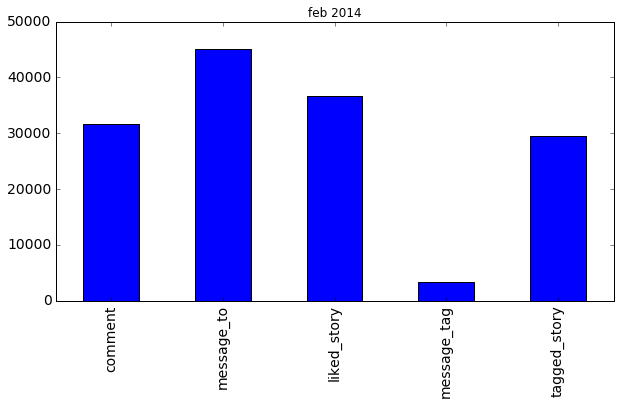

In [89]:
plt.figure(figsize=(20,5))
df_type = pd.DataFrame.from_dict( Counter( feb14['type'] ) , orient='index')
df_type.plot(kind='bar', legend=False, fontsize=14, figsize=(10,5), title='feb 2014')

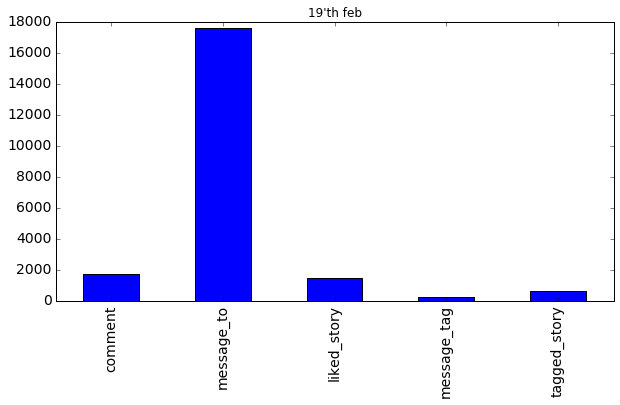

In [106]:
plt.figure(figsize=(20,5))
df_type = pd.DataFrame.from_dict( Counter( feb14_daily[18]['type'] ) , orient='index')
df_type.plot(kind='bar', legend=False, fontsize=14, figsize=(10,5), title='19\'th feb')

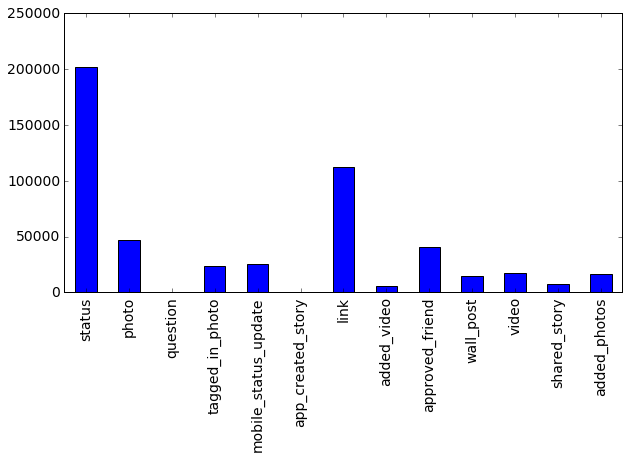

In [86]:
plt.figure(figsize=(20,5))
df_type = pd.DataFrame.from_dict( Counter( df_feed['story_type'] ) , orient='index')
df_type.plot(kind='bar', legend=False, fontsize=14, figsize=(10,5))

In [102]:
for user in feb14_daily[18]['user2']:
    if user not in fb_to_user.values():
        print 'wow'

In [103]:
len(fb_to_user.values())

884

In [4]:
import numpy as np
np.sum([(0.5)**i for i in range(10)])

1.998046875

In [6]:
df_feed.head()

,user1,user2,timestamp,id,type,story_type
518,16d4312521b2cbdee64e6644e29054,2568524213837a25d893463c3e02b6,1373896924,1711db20a687b94b1ab08c0fffc420ec6ceb50a6856f06...,tagged_story,status
519,16d4312521b2cbdee64e6644e29054,2568524213837a25d893463c3e02b6,1373896924,1711db20a687b94b1ab08c0fffc420ec6ceb50a6856f06...,tagged_story,status
520,16d4312521b2cbdee64e6644e29054,2568524213837a25d893463c3e02b6,1373896924,1711db20a687b94b1ab08c0fffc420ec6ceb50a6856f06...,tagged_story,status
521,16d4312521b2cbdee64e6644e29054,2568524213837a25d893463c3e02b6,1373896924,1711db20a687b94b1ab08c0fffc420ec6ceb50a6856f06...,tagged_story,status
522,16d4312521b2cbdee64e6644e29054,2568524213837a25d893463c3e02b6,1373896924,1711db20a687b94b1ab08c0fffc420ec6ceb50a6856f06...,tagged_story,status
